In [2]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [3]:
df_merged = pd.read_csv('df_merged.csv')
df_merged = df_merged.drop(columns=['Cluster'])

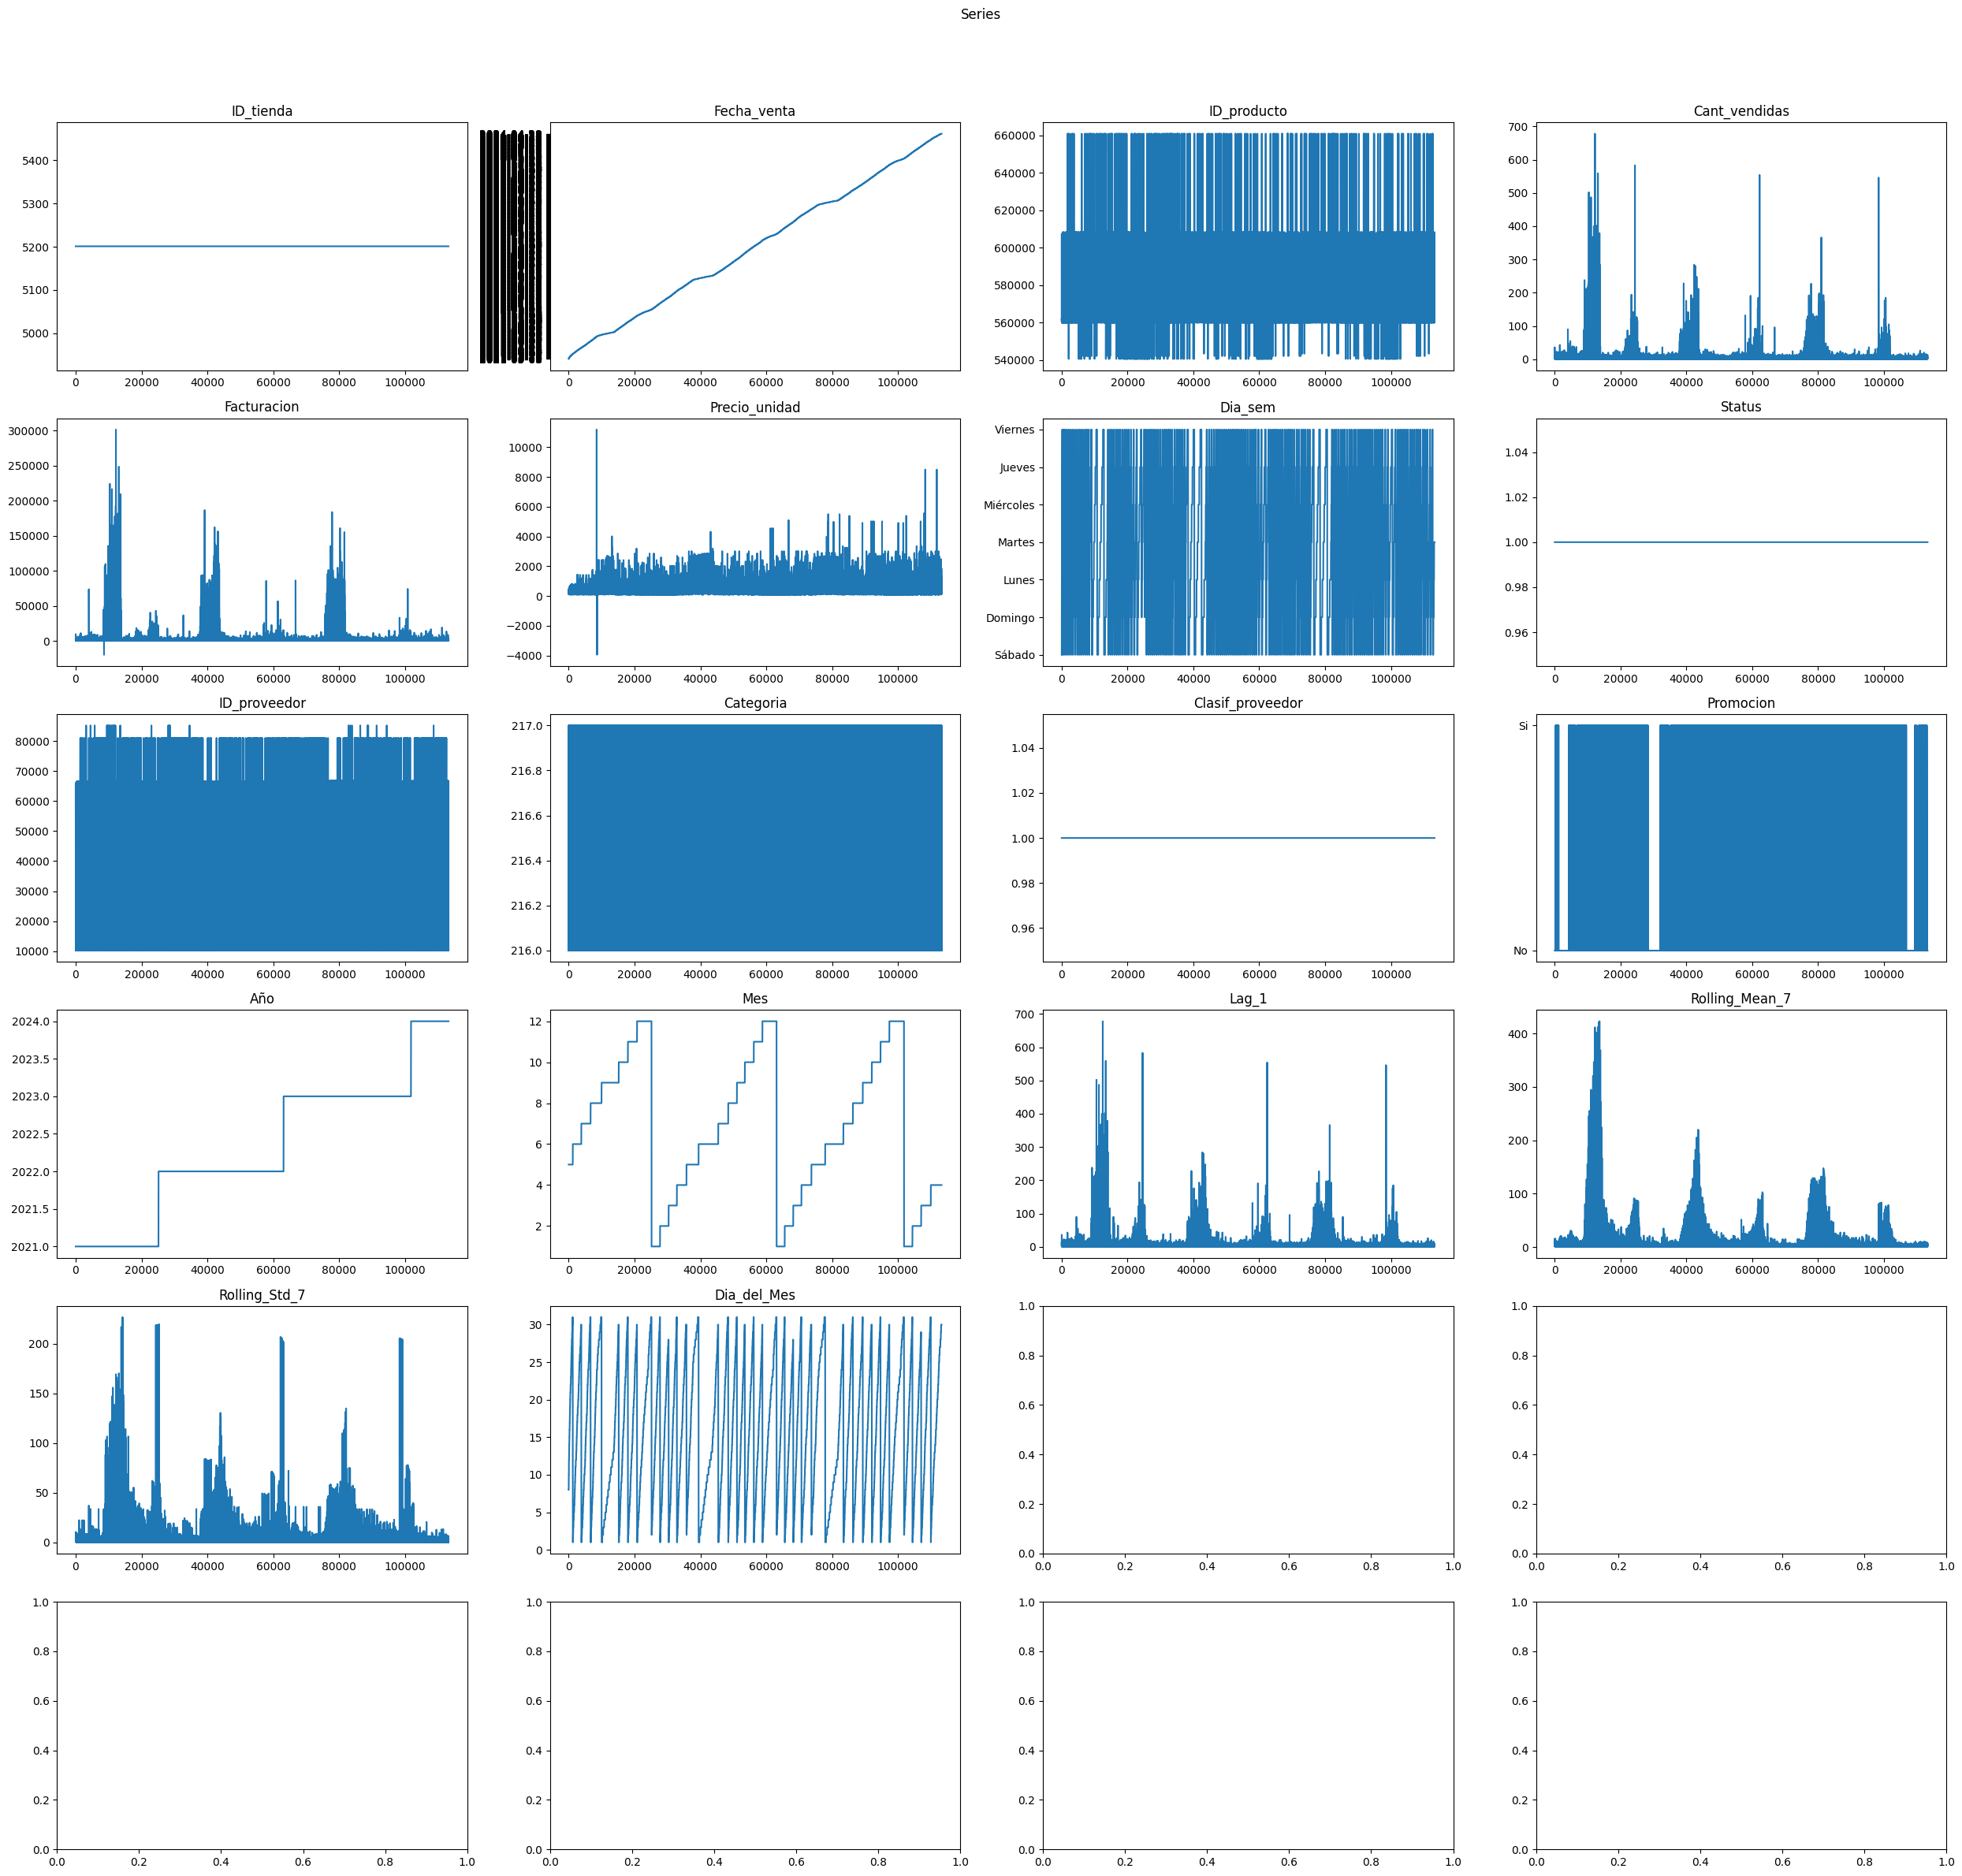

In [4]:
# Configurar la figura y los ejes
fig, axs = plt.subplots(6, 4, figsize=(25, 25))
fig.suptitle('Series')

# Graficar cada columna del DataFrame
for i in range(6):
    for j in range(4):
        idx = i * 4 + j
        if idx >= len(df_merged.columns):  # Evitar el desbordamiento de índices
            continue
        axs[i, j].plot(df_merged.iloc[:, idx].values)
        axs[i, j].set_title(df_merged.columns[idx])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar el diseño para el título
plt.show()

In [5]:
series_lengths = {len(series) for series in df_merged}
print(series_lengths)

{3, 5, 6, 7, 9, 11, 12, 13, 14, 16}


In [6]:
ind = 0
for series in df_merged.columns:
    print(f"[{ind}] {df_merged[series].iloc[0]} {df_merged[series].iloc[-1]}")
    ind += 1

[0] 5201 5201
[1] 2021-05-08 2024-04-30
[2] 561818 600988
[3] 6 4
[4] 1488.0 796.0
[5] 248.0 199.0
[6] Sábado Martes
[7] 1 1
[8] 65987 10214
[9] 216 216
[10] 1 1
[11] No No
[12] 2021 2024
[13] 5 4
[14] 10.0 1.0
[15] 4.857142857142857 4.714285714285714
[16] 3.0237157840738176 3.1997023671109206
[17] 8 30


In [7]:
ind = 0
for series in df_merged.columns:
    print(f"[{ind}] {df_merged[series].index[0]} {df_merged[series].index[len(df_merged[series])-1]}")
    ind += 1

[0] 0 113253
[1] 0 113253
[2] 0 113253
[3] 0 113253
[4] 0 113253
[5] 0 113253
[6] 0 113253
[7] 0 113253
[8] 0 113253
[9] 0 113253
[10] 0 113253
[11] 0 113253
[12] 0 113253
[13] 0 113253
[14] 0 113253
[15] 0 113253
[16] 0 113253
[17] 0 113253


In [8]:
# Convertir la columna Fecha_venta a tipo datetime
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])

# Agrupar los datos por Fecha_venta
grouped = df_merged.groupby('Fecha_venta')

# Iterar sobre cada grupo y extraer las fechas de inicio y fin
ind = 0
for name, group in grouped:
    start_date = group['Fecha_venta'].min()
    end_date = group['Fecha_venta'].max()
    print(f"[{ind}] {start_date} {end_date}")
    ind += 1


[0] 2021-05-08 00:00:00 2021-05-08 00:00:00
[1] 2021-05-09 00:00:00 2021-05-09 00:00:00
[2] 2021-05-10 00:00:00 2021-05-10 00:00:00
[3] 2021-05-11 00:00:00 2021-05-11 00:00:00
[4] 2021-05-12 00:00:00 2021-05-12 00:00:00
[5] 2021-05-13 00:00:00 2021-05-13 00:00:00
[6] 2021-05-14 00:00:00 2021-05-14 00:00:00
[7] 2021-05-15 00:00:00 2021-05-15 00:00:00
[8] 2021-05-16 00:00:00 2021-05-16 00:00:00
[9] 2021-05-17 00:00:00 2021-05-17 00:00:00
[10] 2021-05-18 00:00:00 2021-05-18 00:00:00
[11] 2021-05-19 00:00:00 2021-05-19 00:00:00
[12] 2021-05-20 00:00:00 2021-05-20 00:00:00
[13] 2021-05-21 00:00:00 2021-05-21 00:00:00
[14] 2021-05-22 00:00:00 2021-05-22 00:00:00
[15] 2021-05-23 00:00:00 2021-05-23 00:00:00
[16] 2021-05-24 00:00:00 2021-05-24 00:00:00
[17] 2021-05-25 00:00:00 2021-05-25 00:00:00
[18] 2021-05-26 00:00:00 2021-05-26 00:00:00
[19] 2021-05-27 00:00:00 2021-05-27 00:00:00
[20] 2021-05-28 00:00:00 2021-05-28 00:00:00
[21] 2021-05-29 00:00:00 2021-05-29 00:00:00
[22] 2021-05-30 00:0

In [10]:
# Convertir la columna Fecha_venta a tipo datetime
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])

# Eliminar duplicados en Fecha_venta
df_merged = df_merged.drop_duplicates(subset='Fecha_venta')

# Encontrar la fecha de inicio más temprana y la fecha de fin más tardía
start_date = df_merged['Fecha_venta'].min()
end_date = df_merged['Fecha_venta'].max()

# Crear un DataFrame con el rango de fechas completo
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_full = pd.DataFrame(date_range, columns=['Fecha_venta'])

# Extender cada serie para que coincida con el rango de fechas completo
for column in df_merged.columns:
    if column != 'Fecha_venta':
        temp_df = df_merged[['Fecha_venta', column]].set_index('Fecha_venta')
        temp_df = temp_df.reindex(date_range)
        df_full[column] = temp_df[column].values

# Imprimir las fechas de inicio y fin de cada serie ajustada
ind = 0
for series in df_full.columns:
    if series == 'Fecha_venta':
        continue
    print(f"[{ind}] {df_full['Fecha_venta'].iloc[0]} {df_full['Fecha_venta'].iloc[-1]}")
    ind += 1


[0] 2021-05-08 00:00:00 2024-04-30 00:00:00
[1] 2021-05-08 00:00:00 2024-04-30 00:00:00
[2] 2021-05-08 00:00:00 2024-04-30 00:00:00
[3] 2021-05-08 00:00:00 2024-04-30 00:00:00
[4] 2021-05-08 00:00:00 2024-04-30 00:00:00
[5] 2021-05-08 00:00:00 2024-04-30 00:00:00
[6] 2021-05-08 00:00:00 2024-04-30 00:00:00
[7] 2021-05-08 00:00:00 2024-04-30 00:00:00
[8] 2021-05-08 00:00:00 2024-04-30 00:00:00
[9] 2021-05-08 00:00:00 2024-04-30 00:00:00
[10] 2021-05-08 00:00:00 2024-04-30 00:00:00
[11] 2021-05-08 00:00:00 2024-04-30 00:00:00
[12] 2021-05-08 00:00:00 2024-04-30 00:00:00
[13] 2021-05-08 00:00:00 2024-04-30 00:00:00
[14] 2021-05-08 00:00:00 2024-04-30 00:00:00
[15] 2021-05-08 00:00:00 2024-04-30 00:00:00
[16] 2021-05-08 00:00:00 2024-04-30 00:00:00


In [12]:
max_len = max(series_lengths)
longest_series = None
for series in df_merged:
    if len(series) == max_len:
        longest_series = series

In [15]:
# Convertir la columna Fecha_venta a tipo datetime
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])

# Eliminar duplicados en Fecha_venta
df_merged = df_merged.drop_duplicates(subset='Fecha_venta')

# Encontrar la fecha de inicio y fin más tempranas y tardías respectivamente
start_date = df_merged['Fecha_venta'].min()
end_date = df_merged['Fecha_venta'].max()

# Crear un DataFrame con el rango de fechas completo
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df_full = pd.DataFrame(date_range, columns=['Fecha_venta'])

# Encontrar la longitud de la serie más larga
longest_series_len = len(df_full)

# Reindexar todas las series para que coincidan con el rango de fechas de la serie más larga
problems_index = []
for column in df_merged.columns:
    if column != 'Fecha_venta':
        temp_df = df_merged[['Fecha_venta', column]].set_index('Fecha_venta')
        if len(temp_df) != longest_series_len:
            problems_index.append(column)
        temp_df = temp_df.reindex(date_range)
        df_full[column] = temp_df[column].values

# Imprimir las fechas de inicio y fin de cada serie ajustada
ind = 0
for series in df_full.columns:
    if series == 'Fecha_venta':
        continue
    print(f"[{ind}] {df_full['Fecha_venta'].iloc[0]} {df_full['Fecha_venta'].iloc[-1]}")
    ind += 1


[0] 2021-05-08 00:00:00 2024-04-30 00:00:00
[1] 2021-05-08 00:00:00 2024-04-30 00:00:00
[2] 2021-05-08 00:00:00 2024-04-30 00:00:00
[3] 2021-05-08 00:00:00 2024-04-30 00:00:00
[4] 2021-05-08 00:00:00 2024-04-30 00:00:00
[5] 2021-05-08 00:00:00 2024-04-30 00:00:00
[6] 2021-05-08 00:00:00 2024-04-30 00:00:00
[7] 2021-05-08 00:00:00 2024-04-30 00:00:00
[8] 2021-05-08 00:00:00 2024-04-30 00:00:00
[9] 2021-05-08 00:00:00 2024-04-30 00:00:00
[10] 2021-05-08 00:00:00 2024-04-30 00:00:00
[11] 2021-05-08 00:00:00 2024-04-30 00:00:00
[12] 2021-05-08 00:00:00 2024-04-30 00:00:00
[13] 2021-05-08 00:00:00 2024-04-30 00:00:00
[14] 2021-05-08 00:00:00 2024-04-30 00:00:00
[15] 2021-05-08 00:00:00 2024-04-30 00:00:00
[16] 2021-05-08 00:00:00 2024-04-30 00:00:00


/tmp/ipykernel_554/335641069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])


In [19]:
def nan_counter(df):
    nan_polluted_series_counter = 0
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)



In [20]:
nan_counter(df_merged)

0


In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1081 entries, 0 to 113103
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_tienda         1081 non-null   int64         
 1   Fecha_venta       1081 non-null   datetime64[ns]
 2   ID_producto       1081 non-null   category      
 3   Cant_vendidas     1081 non-null   int64         
 4   Facturacion       1081 non-null   float64       
 5   Precio_unidad     1081 non-null   float64       
 6   Dia_sem           1081 non-null   category      
 7   Status            1081 non-null   int64         
 8   ID_proveedor      1081 non-null   int64         
 9   Categoria         1081 non-null   int64         
 10  Clasif_proveedor  1081 non-null   int64         
 11  Promocion         1081 non-null   category      
 12  Año               1081 non-null   category      
 13  Mes               1081 non-null   category      
 14  Lag_1             1081 non-

In [28]:
df_merged['Año'] = df_merged['Año'].astype('category')
df_merged['Mes'] = df_merged['Mes'].astype('category')
df_merged['Dia_del_Mes'] = df_merged['Dia_del_Mes'].astype('category')
df_merged['ID_producto'] = df_merged['ID_producto'].astype('category')
df_merged['Dia_sem'] = df_merged['Dia_sem'].astype('category')
df_merged['Status'] = df_merged['Status'].astype('category')
df_merged['ID_proveedor'] = df_merged['ID_proveedor'].astype('category')
df_merged['Categoria'] = df_merged['Categoria'].astype('category')
df_merged['Promocion'] = df_merged['Promocion'].astype('category')

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Crear una copia del DataFrame original para evitar modificarlo directamente
df_scaled = df_merged.copy()

# Identificar las columnas numéricas (int y float)
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns

# Aplicar MinMaxScaler a cada columna numérica
scaler = MinMaxScaler()
df_scaled[numeric_columns] = scaler.fit_transform(df_merged[numeric_columns])

# Mostrar una muestra del DataFrame escalado
print(df_scaled.head())



    ID_tienda Fecha_venta ID_producto  Cant_vendidas  Facturacion  \
0         0.0  2021-05-08      561818       0.064103     0.028167   
8         0.0  2021-05-09      607064       0.012821     0.011803   
27        0.0  2021-05-10      561796       0.025641     0.020545   
52        0.0  2021-05-11      600817       0.025641     0.008302   
75        0.0  2021-05-12      604235       0.000000     0.003181   

    Precio_unidad    Dia_sem Status ID_proveedor Categoria  Clasif_proveedor  \
0        0.081553     Sábado      1        65987       216               0.0   
8        0.123786    Domingo      1        10214       216               0.0   
27       0.140291      Lunes      1        22010       216               0.0   
52       0.041262     Martes      1        31064       216               0.0   
75       0.077184  Miércoles      1        10214       216               0.0   

   Promocion   Año Mes     Lag_1  Rolling_Mean_7  Rolling_Std_7 Dia_del_Mes  
0         No  2021   5  0.

In [31]:
# Identificar las columnas numéricas (int y float)
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns

# Aplicar MinMaxScaler a cada columna numérica
scaler = MinMaxScaler()
df_merged[numeric_columns] = scaler.fit_transform(df_merged[numeric_columns])

# Preparar los datos para MiniSom
data_for_som = df_merged[numeric_columns].values

# Calcular las dimensiones del SOM
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_merged))))

# Crear y entrenar el SOM
som = MiniSom(som_x, som_y, data_for_som.shape[1], sigma=0.3, learning_rate=0.1)
som.random_weights_init(data_for_som)
som.train(data_for_som, 50000)

In [33]:
df_scaled

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes
0,0.0,2021-05-08,561818,0.064103,0.028167,0.081553,Sábado,1,65987,216,0.0,No,2021,5,0.047368,0.042654,0.042617,8
8,0.0,2021-05-09,607064,0.012821,0.011803,0.123786,Domingo,1,10214,216,0.0,No,2021,5,0.021053,0.020537,0.017124,9
27,0.0,2021-05-10,561796,0.025641,0.020545,0.140291,Lunes,1,22010,216,0.0,No,2021,5,0.000000,0.012638,0.022178,10
52,0.0,2021-05-11,600817,0.025641,0.008302,0.041262,Martes,1,31064,216,0.0,No,2021,5,0.010526,0.047393,0.031214,11
75,0.0,2021-05-12,604235,0.000000,0.003181,0.077184,Miércoles,1,10214,216,0.0,No,2021,5,0.010526,0.018957,0.024021,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112541,0.0,2024-04-26,600922,0.012821,0.013563,0.145146,Viernes,1,10214,216,0.0,No,2024,4,0.031579,0.012638,0.030909,26
112668,0.0,2024-04-27,660994,0.000000,0.003901,0.094660,Sábado,1,11094,216,0.0,No,2024,4,0.000000,0.000000,0.000000,27
112878,0.0,2024-04-28,560101,0.012821,0.005961,0.052913,Domingo,1,10214,216,0.0,Si,2024,4,0.000000,0.001580,0.005327,28
113017,0.0,2024-04-29,562018,0.000000,0.002501,0.060680,Lunes,1,11052,216,0.0,No,2024,4,0.005263,0.001580,0.005327,29


In [34]:
df_merged

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes
0,0.0,2021-05-08,561818,0.064103,0.028167,0.081553,Sábado,1,65987,216,0.0,No,2021,5,0.047368,0.042654,0.042617,8
8,0.0,2021-05-09,607064,0.012821,0.011803,0.123786,Domingo,1,10214,216,0.0,No,2021,5,0.021053,0.020537,0.017124,9
27,0.0,2021-05-10,561796,0.025641,0.020545,0.140291,Lunes,1,22010,216,0.0,No,2021,5,0.000000,0.012638,0.022178,10
52,0.0,2021-05-11,600817,0.025641,0.008302,0.041262,Martes,1,31064,216,0.0,No,2021,5,0.010526,0.047393,0.031214,11
75,0.0,2021-05-12,604235,0.000000,0.003181,0.077184,Miércoles,1,10214,216,0.0,No,2021,5,0.010526,0.018957,0.024021,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112541,0.0,2024-04-26,600922,0.012821,0.013563,0.145146,Viernes,1,10214,216,0.0,No,2024,4,0.031579,0.012638,0.030909,26
112668,0.0,2024-04-27,660994,0.000000,0.003901,0.094660,Sábado,1,11094,216,0.0,No,2024,4,0.000000,0.000000,0.000000,27
112878,0.0,2024-04-28,560101,0.012821,0.005961,0.052913,Domingo,1,10214,216,0.0,Si,2024,4,0.000000,0.001580,0.005327,28
113017,0.0,2024-04-29,562018,0.000000,0.002501,0.060680,Lunes,1,11052,216,0.0,No,2024,4,0.005263,0.001580,0.005327,29


In [32]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

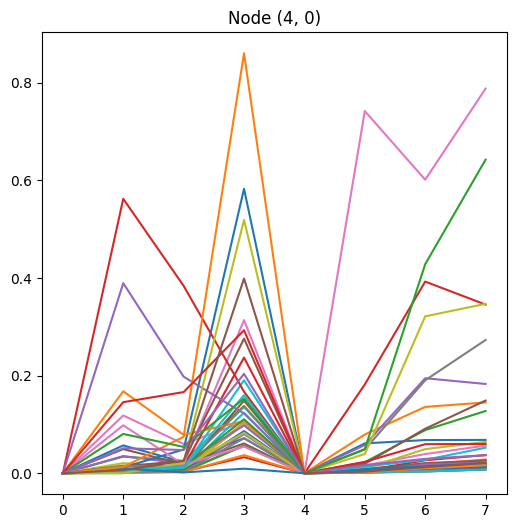

In [36]:
# Aplicar MinMaxScaler a cada columna numérica
scaler = MinMaxScaler()
df_merged[numeric_columns] = scaler.fit_transform(df_merged[numeric_columns])

# Preparar los datos para MiniSom
data_for_som = df_merged[numeric_columns].values

# Calcular las dimensiones del SOM
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_merged))))

# Crear y entrenar el SOM
som = MiniSom(som_x, som_y, data_for_som.shape[1], sigma=0.3, learning_rate=0.1)
som.random_weights_init(data_for_som)
som.train(data_for_som, 50000)

# Obtener el mapeo de los nodos ganadores
win_map = som.win_map(data_for_som)

# Definir la función para graficar el SOM
def plot_som_series_averaged_center(som_x, som_y, win_map):
    plt.figure(figsize=(som_x, som_y))
    for pos, series in win_map.items():
        average_series = np.mean(series, axis=0)
        plt.plot(average_series)
        plt.title(f"Node {pos}")
    plt.show()

# Graficar el SOM con los nodos ganadores
plot_som_series_averaged_center(som_x, som_y, win_map)

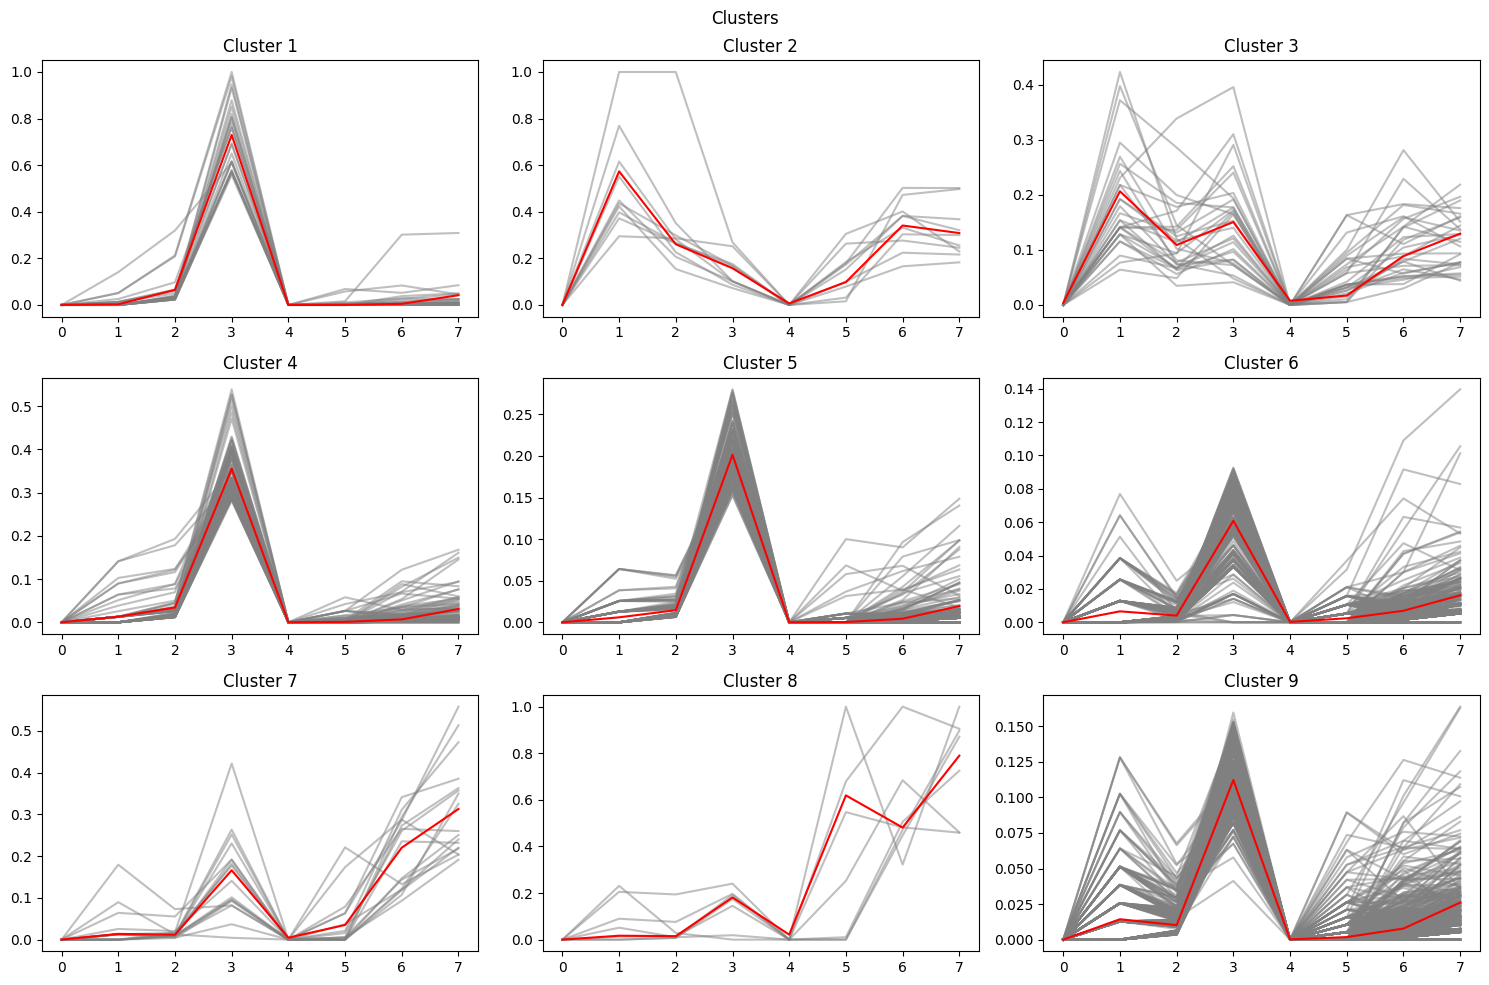

In [43]:
# Convertir la columna Fecha_venta a tipo datetime
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])

# Identificar las columnas numéricas (int y float)
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns

# Aplicar MinMaxScaler a cada columna numérica
scaler = MinMaxScaler()
df_merged[numeric_columns] = scaler.fit_transform(df_merged[numeric_columns])

# Preparar los datos para MiniSom
data_for_som = df_merged[numeric_columns].values

# Calcular las dimensiones del SOM para un número reducido de clústeres
som_x = 3
som_y = 3

# Crear y entrenar el SOM
som = MiniSom(som_x, som_y, data_for_som.shape[1], sigma=0.3, learning_rate=0.1)
som.random_weights_init(data_for_som)
som.train(data_for_som, 50000)

# Obtener el mapeo de los nodos ganadores
win_map = som.win_map(data_for_som)

# Definir la función para graficar el SOM
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(15, 10))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[x, y].plot(series, c="gray", alpha=0.5)
                axs[x, y].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])), c="red")
            cluster_number = x * som_y + y + 1
            axs[x, y].set_title(f"Cluster {cluster_number}")
    plt.tight_layout()
    plt.show()

# Graficar el SOM con los nodos ganadores
plot_som_series_dba_center(som_x, som_y, win_map)

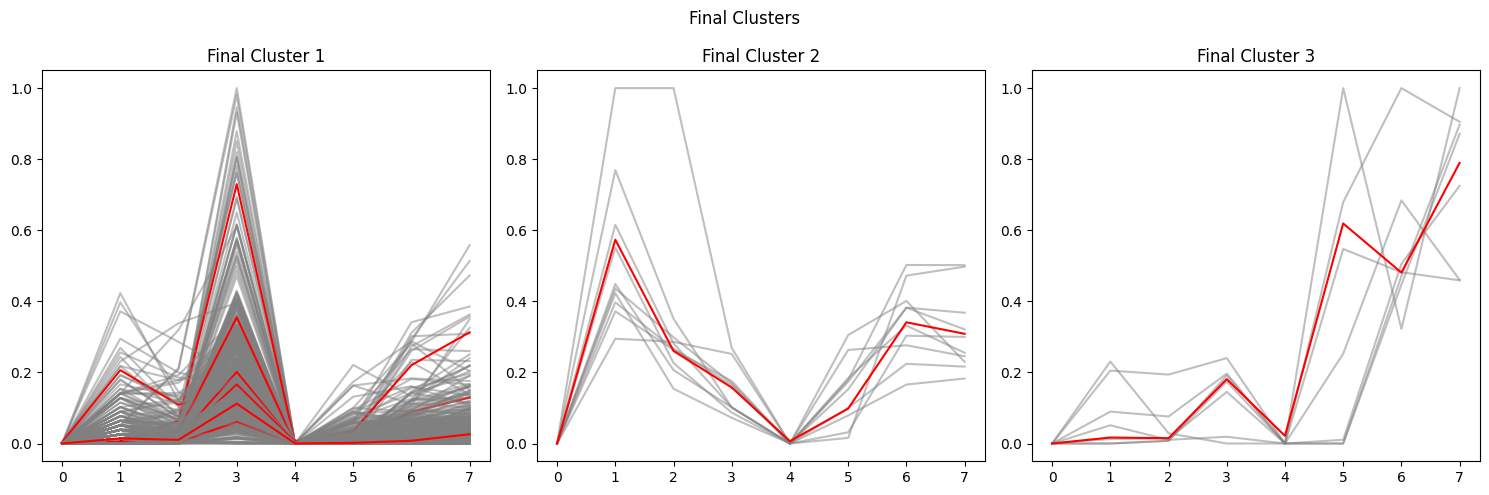

In [44]:
from sklearn.cluster import KMeans

# Obtener los centroides de los clústeres del SOM
centroides = np.array([som.get_weights()[x, y] for x in range(som_x) for y in range(som_y)])

# Aplicar K-means para reducir a menos clústeres
num_final_clusters = 3
kmeans = KMeans(n_clusters=num_final_clusters)
final_clusters = kmeans.fit_predict(centroides)

# Definir la función para graficar el SOM con los clústeres fusionados
def plot_final_clusters(som_x, som_y, win_map, final_clusters):
    fig, axs = plt.subplots(1, num_final_clusters, figsize=(15, 5))
    fig.suptitle('Final Clusters')
    for cluster_id in range(num_final_clusters):
        cluster_indices = np.where(final_clusters == cluster_id)[0]
        for idx in cluster_indices:
            x, y = divmod(idx, som_y)
            if (x, y) in win_map.keys():
                for series in win_map[(x, y)]:
                    axs[cluster_id].plot(series, c="gray", alpha=0.5)
                axs[cluster_id].plot(dtw_barycenter_averaging(np.vstack(win_map[(x, y)])), c="red")
        axs[cluster_id].set_title(f"Final Cluster {cluster_id + 1}")
    plt.tight_layout()
    plt.show()

# Graficar los clústeres fusionados
plot_final_clusters(som_x, som_y, win_map, final_clusters)


In [45]:
final_clusters

array([0, 1, 0, 0, 0, 0, 0, 2, 0], dtype=int32)